In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re, os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm
from transformers import BertConfig, BertModel
import transformers
import torch 
import torch.nn as nn
from sklearn import model_selection
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn import metrics

# Reading Dataset 

In [ ]:
authentic = pd.read_csv("/content/drive/MyDrive/BERT Bengali Fake News/Authentic-48K.csv")
fake = pd.read_csv("/content/drive/MyDrive/BERT Bengali Fake News/Fake-1K.csv")
label_authentic = pd.read_csv("/content/drive/MyDrive/BERT Bengali Fake News/LabeledAuthentic-7K.csv")
label_fake = pd.read_csv("/content/drive/MyDrive/BERT Bengali Fake News/LabeledFake-1K.csv")


# Overview of the Dataset

In [ ]:
print("Shape of authentic is :", authentic.shape)
authentic.head()

Shape of authentic is : (48678, 7)


,articleID,domain,date,category,headline,content,label
0,1,jagonews24.com,2018-09-19 17:48:18,Education,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজ",গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,1
1,2,jagonews24.com,2018-09-19 17:48:19,National,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারিশ,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,1
2,3,jagonews24.com,2018-09-19 17:48:20,National,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,1
3,4,jagonews24.com,2018-09-19 17:48:21,Crime,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,1
4,5,jagonews24.com,2018-09-19 17:48:21,National,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,1


In [ ]:
authentic.label.value_counts()

1    48678
Name: label, dtype: int64

In [ ]:
print("Shape of fake is :", fake.shape)
fake.head()

Shape of fake is : (1299, 7)


,articleID,domain,date,category,headline,content,label
0,1,channeldhaka.news,2019-03-14T13:34:14+00:00,International,মুরগির হামলায় শেয়াল নিহত,"বাংলায় একটা প্রবাদ আছে, শেয়ালের কাছে মুরগী বর্...",0
1,2,earki.com,"সেম্বর ১৭, ২০১৮",Miscellaneous,বিটিভিতে যেবার আমি ইন্টারভিউ দিতে গেলাম,"BTV থেকে লোকজন আসছে, ইন্টারভিউ নিবে।চারজনের টি...",0
2,3,earki.com,"২০:৩৯, জানুয়ারি ১৪, ২০১৯",Miscellaneous,বিদেশ থেকে উন্নতমানের বিরোধীদল আমদানি করার পরা...,অদ্ভুত বিরোধীদলহীনতায় ভুগছে সরকার। এ এক অন্যরক...,0
3,4,channeldhaka.news,2018-06-30T15:56:47+00:00,Sports,অবসর নেয়ার ঘোষণা দিলেন মেসি !,রাশিয়া বিশ্বকাপ নকআউট পর্বে ফ্রান্সের সাথে ৪-৩...,0
4,5,motikontho.wordpress.com,2013-03-05T21:55:45+00:00,Miscellaneous,"মাদারফাকার নহে, ব্রাদারফাকার: সাকা | দৈনিক মতি...","নিজস্ব মতিবেদক‘মাদারফাকার নহে, আমি ব্রাদারফাকা...",0


In [ ]:
fake.label.value_counts()

0    1299
Name: label, dtype: int64

In [ ]:
print("Shape of label_authentic is :",label_authentic.shape)
label_authentic.head()

Shape of label_authentic is : (7202, 9)


,articleID,domain,date,category,source,relation,headline,content,label
0,1,bd-pratidin.com,2018-09-20 08:16:43,Sports,আফগান ক্রিকেট বোর্ড (এসিবি) প্রধান,Related,হঠাৎ আফগান ক্রিকেট বোর্ড প্রধানের পদত্যাগ,ক্রিকেট বিশ্বের নতুন চমকের নাম আফগানিস্তান। কয়...,1.0
1,2,jugantor.com,2018-09-20 20:20:20,Sports,Reporter,Related,টস হেরে বোলিংয়ে বাংলাদেশ,এশিয়া কাপের ষষ্ঠ ম্যাচে বাংলাদেশ দলের বিপক্ষে ...,0.0
2,3,bd24live.com,2018-09-20 16:39:40,National,Reporter,Related,রাজধানীতে বিশেষ অভিযানে আটক ৪৩,রাজধানীতে মাদক বিরোধী বিশেষ অভিযান পরিচালনা কর...,1.0
3,4,bd24live.com,2018-09-19 18:27:56,National,জননিরাপত্তা বিভাগের সচিব,Related,উস্কানি রোধে নজরদারি থাকবে সামাজিক যোগাযোগ মাধ...,সনাতন ধর্মাবলম্বীদের সবচেয়ে বড় ধর্মীয় উৎসব দুর...,1.0
4,5,somoynews.tv,2018-09-20 10:15:28,Finance,পেট্রোল পাম্প মালিক সমিতি সভাপতি,Related,"'যেখানে তেল আসত ৭ দিনে, এখন তা আসবে অতি দ্রুত'",ভারত থেকে পাইপ লাইনের মাধ্যমে সরাসরি দেশে জ্বা...,0.0


In [ ]:
label_authentic.label.value_counts()

1.0    3964
0.0    3238
Name: label, dtype: int64

In [ ]:
print("Shape of label_fake is :",label_fake.shape)
label_fake.head()

Shape of label_fake is : (1299, 10)


,articleID,domain,date,category,source,relation,headline,content,label,F-type
0,1,channeldhaka.news,2019-03-14T13:34:14+00:00,International,Reporter,Unrelated,মুরগির হামলায় শেয়াল নিহত,"বাংলায় একটা প্রবাদ আছে, শেয়ালের কাছে মুরগী বর্...",0,Satire
1,2,earki.com,"সেম্বর ১৭, ২০১৮",Miscellaneous,Reporter,Unrelated,বিটিভিতে যেবার আমি ইন্টারভিউ দিতে গেলাম,"BTV থেকে লোকজন আসছে, ইন্টারভিউ নিবে।চারজনের টি...",0,Satire
2,3,earki.com,"২০:৩৯, জানুয়ারি ১৪, ২০১৯",Miscellaneous,Reporter,Unrelated,বিদেশ থেকে উন্নতমানের বিরোধীদল আমদানি করার পরা...,অদ্ভুত বিরোধীদলহীনতায় ভুগছে সরকার। এ এক অন্যরক...,0,Satire
3,4,channeldhaka.news,2018-06-30T15:56:47+00:00,Sports,Reporter,Unrelated,অবসর নেয়ার ঘোষণা দিলেন মেসি !,রাশিয়া বিশ্বকাপ নকআউট পর্বে ফ্রান্সের সাথে ৪-৩...,0,Satire
4,5,motikontho.wordpress.com,2013-03-05T21:55:45+00:00,Miscellaneous,Reporter,Unrelated,"মাদারফাকার নহে, ব্রাদারফাকার: সাকা | দৈনিক মতি...","নিজস্ব মতিবেদক‘মাদারফাকার নহে, আমি ব্রাদারফাকা...",0,Satire


In [ ]:
label_fake.label.value_counts()

0    1299
Name: label, dtype: int64

# Concatenating Datasets

In [ ]:
authentic = authentic.loc[:, ['content', 'label']]
fake = fake.loc[:, ['content', 'label']]

train = pd.concat([authentic, fake], axis=0, ignore_index=True)

label_authentic = label_authentic.loc[:, ['content', 'label']]
label_fake = label_fake.loc[:, ['content', 'label']]

test = pd.concat([label_authentic, label_fake], axis=0, ignore_index=True)
test['label'] = test.label.astype(int)

df = pd.concat([train, test], axis=0, ignore_index=True) 


In [ ]:
print("Shape of train is {}".format(df.shape))

Shape of train is (58478, 2)


# Balance, Imbalance check of train and test

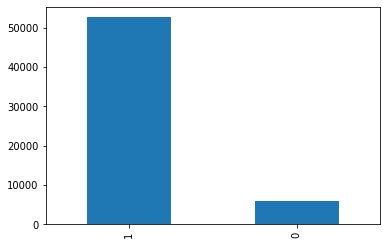

In [ ]:
df['label'].value_counts().plot(kind='bar') 

# Word Counting

In [ ]:
# Average word in df
df_word_average = np.mean(df['content'].apply(lambda x: len(x.split())))
print("Average word in df is {}".format(df_word_average))

# Minimum word in train
df_word_minimum = np.min(df['content'].apply(lambda x: len(x.split())))
print("Minimum word in df is {}".format(df_word_minimum))


# Maximum word in train
df_word_maximum = np.max(df['content'].apply(lambda x: len(x.split())))
print("Maximum word in train is {}".format(df_word_maximum))


Average word in df is 274.9600533533979
Minimum word in df is 0
Maximum word in train is 4788


# Dataset Cleaning

In [ ]:
# Taking those rows where have > 100 words 
df = df[df['content'].apply(lambda x: len(x.split()) > 100 )].reset_index(drop=True) 
print("Shape of df is {}".format(df.shape))


Shape of df is (52526, 2)


In [ ]:
# Loading bengali stop words file
with open('/content/drive/MyDrive/BERT Bengali Fake News/stopwords-bn.txt', 'r', encoding='utf-8-sig') as f:
    stop_word = f.read() 
    stop_word = stop_word.replace(" ", "") 
    stop_word = stop_word.split('\n') 
    print(stop_word) 

['অতএব', 'অথচ', 'অথবা', 'অনুযায়ী', 'অনেক', 'অনেকে', 'অনেকেই', 'অন্তত', 'অন্য', 'অবধি', 'অবশ্য', 'অর্থাত', 'আই', 'আগামী', 'আগে', 'আগেই', 'আছে', 'আজ', 'আদ্যভাগে', 'আপনার', 'আপনি', 'আবার', 'আমরা', 'আমাকে', 'আমাদের', 'আমার', 'আমি', 'আর', 'আরও', 'ই', 'ইত্যাদি', 'ইহা', 'উচিত', 'উত্তর', 'উনি', 'উপর', 'উপরে', 'এ', 'এঁদের', 'এঁরা', 'এই', 'একই', 'একটি', 'একবার', 'একে', 'এক্', 'এখন', 'এখনও', 'এখানে', 'এখানেই', 'এটা', 'এটাই', 'এটি', 'এত', 'এতটাই', 'এতে', 'এদের', 'এব', 'এবং', 'এবার', 'এমন', 'এমনকী', 'এমনি', 'এর', 'এরা', 'এল', 'এস', 'এসে', 'ঐ', 'ও', 'ওঁদের', 'ওঁর', 'ওঁরা', 'ওই', 'ওকে', 'ওখানে', 'ওদের', 'ওর', 'ওরা', 'কখনও', 'কত', 'কবে', 'কমনে', 'কয়েক', 'কয়েকটি', 'করছে', 'করছেন', 'করতে', 'করবে', 'করবেন', 'করলে', 'করলেন', 'করা', 'করাই', 'করায়', 'করার', 'করি', 'করিতে', 'করিয়া', 'করিয়ে', 'করে', 'করেই', 'করেছিলেন', 'করেছে', 'করেছেন', 'করেন', 'কাউকে', 'কাছ', 'কাছে', 'কাজ', 'কাজে', 'কারও', 'কারণ', 'কি', 'কিংবা', 'কিছু', 'কিছুই', 'কিন্তু', 'কী', 'কে', 'কেউ', 'কেউই', 'কেখা', 'কেন', 'কোটি', 'কোন', 'কোনও'

In [ ]:
def clean_text(text):
    row = str(text)
    row = row.replace('\n', ' ')
    row = row.replace('\t', ' ')
    row = row.replace('\\', "")
    row = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', row)
    row = re.sub(' +', ' ', row)
    row = row.replace("।", "")
    row = re.sub('[১২৩৪৫৬৭৮৯০]', '', row)
    row = re.sub('[1234567890]', '', row) 
    row = row.replace('’', '')
    row = row.replace('‘', '')
    
    # remove stopwords
    # Removing stop words
    row = row.split()
    row = [w for w in row if not w in stop_word]
    row = " ".join(row)
    return row

In [ ]:
df['content'] = df['content'].apply(lambda x: clean_text(x))
print("Shape of df is {}".format(df.shape))

Shape of df is (52526, 2)


# Visualizing some text and label

In [ ]:
for i in range(5):
    print(df['label'][i])
    print(df['content'][i])

1
গত সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে বাকৃবি উপাচার্যের কার্যালয়ে হট্টগোলের ঘটনায় দুইজনকে সাময়িক বরখাস্ত ছয় শোকজ বিশ্ববিদ্যালয় প্রশাসন বুধবার বিশ্ববিদ্যালয় বাকৃবি রেজিস্ট্রার সাইফুল ইসলাম স্বাক্ষরিত এক নোটিশে দিনের উপযুক্ত দেয়ার নির্দেশ দেয়া হয়েছে এদিকে ঘটনায় আন্দোলনের একাত্বতা প্রকাশ করায় হামলার শিকার হয়ে কারিগরি কর্মচারী পরিষদের সভাপতি সম্পাদক হাসপাতালে ভর্তি হয়েছেন সাময়িক বরখাস্তরা হলেন শিক্ষা বিষয়ক শাখার কর্মচারী য় শ্রেণির সম্পাদক মো মোশারফ হোসেন কর্মকর্তা পরিষদের যুগ্ম সম্পাদক জিয়াউর রহমান টিটু এছাড়া বিশ্ববিদ্যালয় সম্প্রসারণ কেন্দ্রের সহকারী পরিচালক মোহাম্মদ আবুল বাসার আমজাদ ডেপুটি লাইব্রেরিয়ান মোখাইরুল আলম নান্নু মোআবদুল বাতেন ক্রীড়া প্রশিক্ষণ বিভাগের মোহাম্মদ মোস্তাইন কবীর সোহেল সংস্থাপন শাখার সহকারী রেজিস্ট্রার মোহাম্মদ আশিকুল আলম বাচ্চু খামার ব্যবস্থাপনা শাখার অ্যাডিশনাল রেজিস্ট্রার ড মো হেলাল উদ্দীনকে দর্শানোর নোটিশ দেয় প্রশাসন নোটিশে উল্লেখ গত সোমবার দুপুরে সোয়া টার উপাচার্যের অনুমতি ছাড়াই হঠাৎ উপাচার্যের কার্যালয়ে প্রবেশ ছাত্র বিষয়ক উপদেষ্টা প্রক্টর ডিন কাউন্সিলের আহ

In [ ]:
df_word_average = np.mean(df['content'].apply(lambda x: len(x.split())))
print("Average word in df is {}".format(df_word_average)) 

Average word in df is 213.7613562806991


In [ ]:
df['label'].value_counts()

1    47249
0     5277
Name: label, dtype: int64

In [ ]:
df.head()

,content,label
0,গত সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে বাক...,1
1,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় শ্রমিক পা...,1
2,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি হওয়া...,1
3,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,1
4,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে বেসরকারি টেল...,1


# Create Folds

In [ ]:
df = df.copy() 
#df = df.dropna().reset_index(drop=True) 
df["kfold"] = -1

df = df.sample(frac=1).reset_index(drop=True)

kf = model_selection.StratifiedKFold(n_splits=5)

for fold, (trn_, val_) in enumerate(kf.split(X=df, y=df.label.values)):
    print(len(trn_), len(val_))
    df.loc[val_, 'kfold'] = fold

df.to_csv("/content/drive/MyDrive/BERT Bengali Fake News/train_folds.csv", index=False)

42020 10506
42021 10505
42021 10505
42021 10505
42021 10505


# Some Global Variable

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MAX_LEN = 64
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 10
BERT_PATH = "sagorsarker/bangla-bert-base"
MODEL_PATH = "/content/drive/MyDrive/BERT Bengali Fake News/model.bin"
TRAINING_FILE = "/content/drive/MyDrive/BERT Bengali Fake News/train_folds.csv"
TOKENIZER = transformers.BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

# Model

In [ ]:
class BERTBaseUncased(nn.Module):
    def __init__(self):
        super(BERTBaseUncased, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(BERT_PATH, return_dict=False)
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, 1)

    def forward(self, ids, mask, token_type_ids):
        _, o2 = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return output
        

In [ ]:
model = BERTBaseUncased() 

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Dataset

In [ ]:
class BERTDataset:
    def __init__(self, content, label):
        self.review = content
        self.target = label 
        self.tokenizer = TOKENIZER
        self.max_len = MAX_LEN

    def __len__(self):
        return len(self.review)

    def __getitem__(self, item):
        review = str(self.review[item])
        review = " ".join(review.split())

        inputs = self.tokenizer.encode_plus(
            review,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            pad_to_max_length=True,
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "targets": torch.tensor(self.target[item], dtype=torch.float)
        }

# Early Stopping

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
           

# Engine

In [ ]:
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))


def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()

    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets = d["targets"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)


        optimizer.zero_grad()
        outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)

        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()




def eval_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():

        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            targets = d["targets"]

            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

# Training

In [ ]:
def run(fold):
    dfx = pd.read_csv(TRAINING_FILE)

    df_train = dfx[dfx.kfold != fold].reset_index(drop=True)
    df_valid = dfx[dfx.kfold == fold].reset_index(drop=True)
    #print(df_train.shape)
    #print(df_valid.shape)
    train_dataset = BERTDataset(
        content = df_train.content.values,
        label = df_train.label.values
    )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE, 
        num_workers=4 
    )

    valid_dataset = BERTDataset(
        content = df_valid.content.values,
        label = df_valid.label.values
    )

    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size = VALID_BATCH_SIZE,
        num_workers = 2
    ) 


    device = torch.device(DEVICE)
    model = BERTBaseUncased()
    model.to(device)


    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]


    num_train_steps = int(len(df_train) / TRAIN_BATCH_SIZE * EPOCHS)
    optimizer = AdamW(optimizer_parameters, lr=3e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )


    #es = EarlyStopping(patience=5, mode="max") 

    best_accuracy = 0
    for epoch in range(EPOCHS):
      train_fn(train_data_loader, model, optimizer, device, scheduler)
      outputs, targets = eval_fn(valid_data_loader, model, device)
      
      outputs = np.array(outputs) >= 0.5
      accuracy = metrics.accuracy_score(targets, outputs)
      print(f"Accuracy Score = {accuracy}") 
      if accuracy > best_accuracy:
            torch.save(model.state_dict(), MODEL_PATH)
            best_accuracy = accuracy


In [ ]:
for i in range(5):
  run(i) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g

Accuracy Score = 0.915191319246145


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Accuracy Score = 0.9240434037692747


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Accuracy Score = 0.9142394822006472



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input s

Accuracy Score = 0.8780696744717305



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input s

Accuracy Score = 0.888730249381306



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input s

Accuracy Score = 0.894346087949743



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
  0%|          | 0/5253 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_leng

Accuracy Score = 0.8405672948791167



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input s

Accuracy Score = 0.9028174376546735



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
  0%|          | 0/5253 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_leng

Accuracy Score = 0.9024367028364744



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input s

Accuracy Score = 0.8963449457452884


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g

Accuracy Score = 0.8995716325559258


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Accuracy Score = 0.9041408852927177


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Accuracy Score = 0.8995716325559258



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input s

Accuracy Score = 0.9093764873869586


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Accuracy Score = 0.9034745359352689


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Accuracy Score = 0.9018562589243218



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input s

Accuracy Score = 0.9020466444550215



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input s

Accuracy Score = 0.9014754878629224



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input s

Accuracy Score = 0.9036649214659686



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
  0%|          | 0/5253 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_leng

Accuracy Score = 0.9049976201808663


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g

Accuracy Score = 0.8995716325559258


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Accuracy Score = 0.8995716325559258


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Accuracy Score = 0.8995716325559258



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input s

Accuracy Score = 0.8995716325559258


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Accuracy Score = 0.8995716325559258



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input s

Accuracy Score = 0.8995716325559258



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input s

Accuracy Score = 0.8995716325559258



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
  0%|          | 0/5253 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_leng

Accuracy Score = 0.8995716325559258



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input s

Accuracy Score = 0.8995716325559258



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input s

Accuracy Score = 0.8995716325559258


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g

Accuracy Score = 0.916611137553546


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

# Loading Saved Model

In [ ]:
model_saved = BERTBaseUncased()
model_saved.load_state_dict(torch.load(MODEL_PATH))
model_saved.eval()


Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTBaseUncased(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

# Testing with New Data

In [ ]:
def prediction(sentence, model):
    tokenizer = TOKENIZER
    max_len = MAX_LEN
    review = str(sentence)
    review = " ".join(review.split())

    inputs = tokenizer.encode_plus(
        review, None, add_special_tokens=True, max_length=max_len
    )

    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    padding_length = max_len - len(ids)
    ids = ids + ([0] * padding_length)
    mask = mask + ([0] * padding_length)
    token_type_ids = token_type_ids + ([0] * padding_length)

    ids = torch.tensor(ids, dtype=torch.long).unsqueeze(0)
    mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0)
    token_type_ids = torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0)

    #ids = ids.to(DEVICE, dtype=torch.long)
    #token_type_ids = token_type_ids.to(DEVICE, dtype=torch.long)
    #mask = mask.to(DEVICE, dtype=torch.long)

    outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)

    outputs = torch.sigmoid(outputs).cpu().detach().numpy()
    return outputs[0][0]


In [ ]:
# new data 
sentence = "যে লিওনেল মেসির সঙ্গে বার্সেলোনার বন্ধন এককালে অবিচ্ছেদ্য বলে মনে হতো, সেই বন্ধন ছিঁড়েছে আগেই। বার্সেলোনাই আনুষ্ঠানিকভাবে অবিশ্বাস্য ঘোষণাটা দিয়েছে দিন দু-এক হলো। বার্সেলোনা যা বলার বলে দিলেও, মেসি চুপই ছিলেন। আজ সেই নীরবতাও ভাঙছে। ন্যু ক্যাম্পে আজ আনুষ্ঠানিক সংবাদ সম্মেলন ডেকেছেন মেসি। বোঝাই যাচ্ছে, কেন ডেকেছেন। ক্লাব থেকে আনুষ্ঠানিকভাবে আজ বিদায় নিচ্ছেন লিওনেল মেসি। বাংলাদেশ সময় বিকেল চারটায় হবে এই সংবাদ সম্মেলন। মেসির বিদায় নিয়ে এর আগে বার্সেলোনা নিজেদের বিবৃতি দিয়েছে, সে বিবৃতি বিশ্লেষণ করে বার্সা সভাপতি হোয়ান লাপোর্তা সংবাদ সম্মেলনও করেছেন। মেসির পক্ষের গল্পটা জানা এখনো বাকি। আজকের সংবাদ সম্মেলনের পর মেসির দিকের গল্পটাও আর কারওর অজানা থাকবে না। ২১ বছরের সম্পর্ক চুকিয়ে ক্লাব কেন ছাড়ছেন, তা নিয়ে মেসির ব্যাখ্যা জানা যাবে আজ। ক্লাবের ওয়েবসাইট আর বার্সা টিভিতে সরাসরি সম্প্রচারিত হবে সেই সংবাদ সম্মেলন।"

# Cleaning text 
clean_sentence = clean_text(sentence)

# predicting with new text 
predict_result = prediction(clean_sentence, model_saved)
negative_result = 1 - predict_result

# Probability of True new is 
print("True News Probability is :{}".format(predict_result)) 
# Probability of Fake news is 
print("Fake News Probability is :{}".format(negative_result)) 


True News Probability is :0.9203888177871704
Fake News Probability is :0.07961118221282959
